# Imports

In [46]:
pip install requests pandas numpy http.client tqdm matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 65.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 91.6 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [47]:
#Import
import requests
import pandas as pd
import numpy as np
import http.client, json
from urllib.parse import urlparse
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# Utils

In [35]:
def get_data(url):
    parsed_url = urlparse(url)
    conn = http.client.HTTPConnection(parsed_url.netloc)
    conn.request("GET", parsed_url.path)
    res = conn.getresponse()
    data = res.read()
    jsondata = json.loads(data.decode("utf-8"))
    return jsondata

def get_matchs_id(tournamentID = '17', seasonID = '52186'):
    matchs_id = []
    url_root = f"https://www.sofascore.com/api/v1/unique-tournament/{tournamentID}/season/{seasonID}/events/last/"
    hasNextPage = True
    i = 0

    while hasNextPage:
        present_url = url_root + str(i)
        data = get_data(present_url)
        for match in data['events']:
            matchs_id.append(match['id'])
        hasNextPage = data['hasNextPage'] #True or False
        i+=1 #access to nextpage
    
    return matchs_id

def get_date(matchID):
    data = get_data(f"https://www.sofascore.com/api/v1/event/{str(matchID)}")
    date = data['event']['startTimestamp']
    return date

In [20]:
matchs_id = get_matchs_id()

In [43]:
# Construct the forward players structured dataset
forward_players = {}

for id in tqdm(matchs_id):
    data = get_data(f"https://www.sofascore.com/api/v1/event/{id}/lineups")
    for team in ['home', 'away']:
        for player in data[team]['players']:
            
            if player['player']['position'] == 'F': #on ne considère que les attaquants

                key = player['player']['name']
                value = player['statistics']
                value['date'] = get_date(id) #dater les matchs
    
                if key in forward_players:
                    forward_players[key].append(value)
                else:
                    forward_players[key] = []
                    forward_players[key].append(value)



100%|██████████| 380/380 [00:30<00:00, 12.31it/s]


In [44]:
forward_players

{'Bryan Mbeumo': [{'totalPass': 42,
   'accuratePass': 26,
   'totalLongBalls': 2,
   'totalCross': 2,
   'aerialLost': 1,
   'aerialWon': 1,
   'duelLost': 7,
   'duelWon': 6,
   'dispossessed': 5,
   'totalContest': 6,
   'wonContest': 5,
   'blockedScoringAttempt': 1,
   'hitWoodwork': 1,
   'totalOffside': 1,
   'minutesPlayed': 90,
   'touches': 68,
   'rating': 6.9,
   'possessionLostCtrl': 29,
   'expectedGoals': 0.079,
   'ratingVersions': {'original': 6.9, 'alternative': 6.8},
   'expectedAssists': 0.0226552,
   'date': 1714831200},
  {'totalPass': 31,
   'accuratePass': 18,
   'totalLongBalls': 3,
   'accurateLongBalls': 2,
   'goalAssist': 1,
   'totalCross': 1,
   'aerialWon': 1,
   'duelLost': 4,
   'duelWon': 4,
   'challengeLost': 1,
   'dispossessed': 2,
   'totalContest': 2,
   'wonContest': 1,
   'bigChanceCreated': 1,
   'bigChanceMissed': 1,
   'shotOffTarget': 1,
   'onTargetScoringAttempt': 1,
   'blockedScoringAttempt': 1,
   'goals': 1,
   'interceptionWon': 1,


In [48]:
players_name = list(forward_players.keys())
nb_games_played = []
for player in players_name:
    nb_games_played.append(len(forward_players[player]))

In [51]:
# Créer le DataFrame
df = pd.DataFrame({
    'player': players_name,
    'nb_games_played': nb_games_played
})

# Afficher le DataFrame
df.head(140)

,player,nb_games_played
0,Bryan Mbeumo,25
1,Ivan Toney,18
2,Keane Lewis-Potter,33
3,Yoane Wissa,34
4,Kevin Schade,11
...,...,...
135,John McAtee,1
136,Aleksandar Mitrović,1
137,Jay Stansfield,1
138,Mason Burstow,3


In [ ]:
df_sorted = df.sort_values(by='nb_games_played', ascending=True)
df_sorted

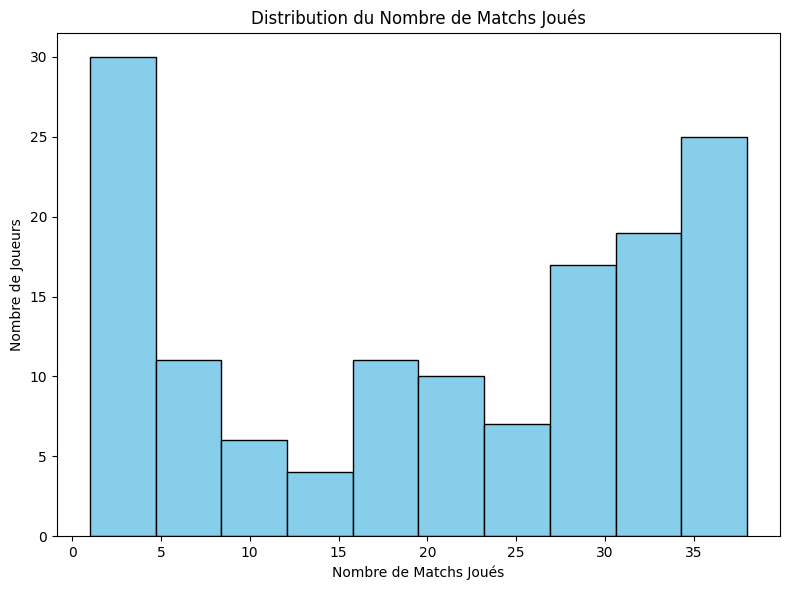

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_sorted['nb_games_played'], color='skyblue', edgecolor='black')
plt.xlabel('Nombre de Matchs Joués')
plt.ylabel('Nombre de Joueurs')
plt.title('Distribution du Nombre de Matchs Joués')
plt.tight_layout()
plt.show()


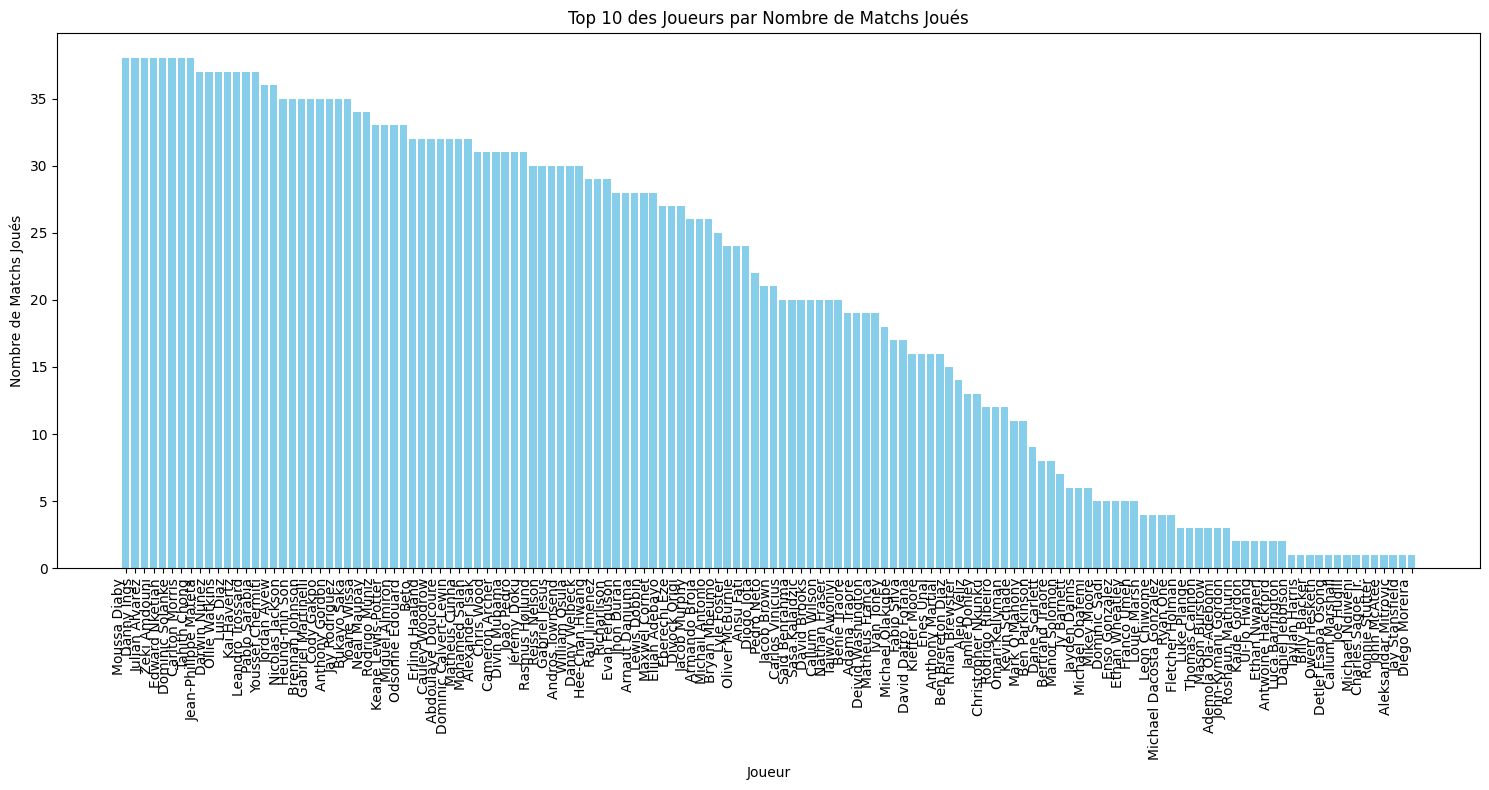

In [61]:
# Limiter aux 10 joueurs ayant joué le plus de matchs
#df_top = df_sorted.head(10)

# Plot
plt.figure(figsize=(15, 8))
plt.bar(df_sorted['player'], df_sorted['nb_games_played'], color='skyblue')
plt.xlabel('Joueur')
plt.ylabel('Nombre de Matchs Joués')
plt.title('Top 10 des Joueurs par Nombre de Matchs Joués')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()
